# Objective
The objective is to create a Real-Time Face Mask Detector which can solve monitoring issues in crowded areas such as Airports, Metros, etc. using CNN and OpenCV.

In [1]:
# Import Libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# Load and Pre-process the dataset
DIRECTORY = "D:\Jupyter\Tests - Deep Learning\Test-7\Real Time Face Mask Detector\dataset"
CATEGORIES = ["with_mask", "without_mask"]

# grab the list of images from our dataset directory, then initialize the list of data (i.e., images) and their labels 
# using Categories('With Mask' and 'Without Mask')
print("[INFO] Loading Images...")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

# Perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

# Split the data into training and testing set
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

[INFO] Loading Images...


In [3]:
# Use ImageDataGenerator to perform data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


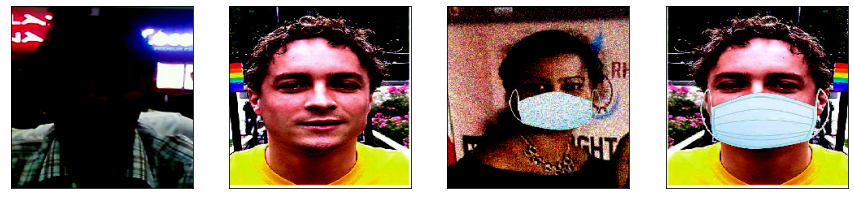

In [4]:
# Visualize Images present in the dataset
plt.figure(0, figsize=(15,15))
for i in range(1,5):
    plt.subplot(1,4,i)
    img = np.squeeze(trainX[np.random.randint(0, trainX.shape[0])])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)

In [6]:
# Design a Convolutional Neural Network (CNN) Model using AveragePooling2D, Flatten, Dense, and Dropout layers

# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the the base model

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will not be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# Compile the Model using Adam optimizer, Binary Crossentropy loss, and accuracy metric functions
print("[INFO] compiling model...")

INIT_LR = 1e-4            #Initial Learning rate
EPOCHS = 30               #Number of Epochs
BS = 32                   #Batch Size

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)

model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

earlystop = EarlyStopping(monitor='val_accuracy', patience = 10, min_delta = 0.01, mode='max')



# Train the Model for 30 epochs

print("[INFO] training head...")

training = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    callbacks=[earlystop])

# Load the model
#model = load_model('mask_detector.model')

[INFO] compiling model...
[INFO] training head...
Epoch 1/30
34/34 [==============================] - 40s 1s/step - loss: 0.4939 - accuracy: 0.7706 - val_loss: 0.1042 - val_accuracy: 0.9783
Epoch 2/30
34/34 [==============================] - 39s 1s/step - loss: 0.1300 - accuracy: 0.9607 - val_loss: 0.0513 - val_accuracy: 0.9891
Epoch 3/30
34/34 [==============================] - 39s 1s/step - loss: 0.0722 - accuracy: 0.9747 - val_loss: 0.0381 - val_accuracy: 0.9891
Epoch 4/30
34/34 [==============================] - 40s 1s/step - loss: 0.0657 - accuracy: 0.9747 - val_loss: 0.0311 - val_accuracy: 0.9928
Epoch 5/30
34/34 [==============================] - 39s 1s/step - loss: 0.0375 - accuracy: 0.9916 - val_loss: 0.0265 - val_accuracy: 0.9928
Epoch 6/30
34/34 [==============================] - 38s 1s/step - loss: 0.0333 - accuracy: 0.9925 - val_loss: 0.0223 - val_accuracy: 0.9928
Epoch 7/30
34/34 [==============================] - 38s 1s/step - loss: 0.0250 - accuracy: 0.9934 - val_loss: 

In [7]:
# make predictions on the testing set
print("[INFO] Predicting the test images")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
print(predIdxs)

[INFO] Predicting the test images
[1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1 0 1 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1
 0 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 0 0 1 1 1
 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0
 0 1 1 1 0 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0
 0 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 1 0 0 0 1 1 0 0 1 1 0
 0 0 0 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 0 0 1
 1 1 0 1 0 0 1 1 1 1 0 0 1 1 0 0 0]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


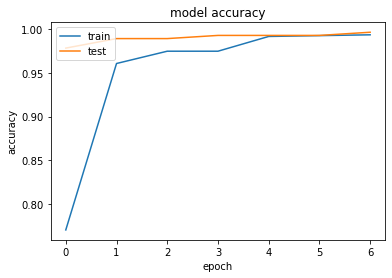

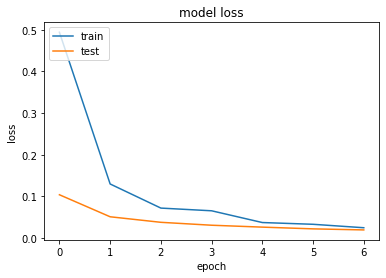

In [8]:
# Plot the training history using the Tensorflow History object returned by model.fit
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in training
print(training.history.keys())
# summarize training for accuracy
plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize traning for loss
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
# Evaluate the Model using model.evaluate method

model.evaluate(testX, testY)

9/9 [==============================] - 6s 673ms/step - loss: 0.0198 - accuracy: 0.9964


[0.019813407212495804, 0.9963768124580383]

In [10]:
# Save the Entire Model using model.save

print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")

[INFO] saving mask detector model...


Now that you have trained the model, test it using a webcam using OpenCV, and detect the Face Masks in real-time

In [1]:
# import the necessary packages
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import imutils
import time
import cv2
import os

def detect_and_predict_mask(frame, faceNet, maskNet):
    # grab the dimensions of the frame and then construct a blob from it
    (h, w) = frame.shape[:2]
    blob = cv2.dnn.blobFromImage(frame, 1.0, (224, 224),(104.0, 177.0, 123.0))

    # pass the blob through the network and obtain the face detections
    faceNet.setInput(blob)
    detections = faceNet.forward()
    print(detections.shape)

    # initialize our list of faces, their corresponding locations and the list of predictions 
    # from our face mask network
    faces = []
    locs = []
    preds = []

    # loop over the detections
    for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the detection
        confidence = detections[0, 0, i, 2]

        # filter out weak detections by ensuring the confidence is greater than the minimum confidence
        if confidence > 0.5:
            # compute the (x, y)-coordinates of the bounding box for the object
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")

            # ensure the bounding boxes fall within the dimensions of the frame
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))

            # extract the face ROI, convert it from BGR to RGB channel
            # ordering, resize it to 224x224, and preprocess it
            face = frame[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (224, 224))
            face = img_to_array(face)
            face = preprocess_input(face)

            # add the face and bounding boxes to their respective lists
            faces.append(face)
            locs.append((startX, startY, endX, endY))

    # only make a predictions if at least one face was detected
    if len(faces) > 0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        preds = maskNet.predict(faces, batch_size=32)

    # return a 2-tuple of the face locations and their corresponding locations
    return (locs, preds)

# load our serialized face detector model from disk
prototxtPath = "deploy.prototxt"
weightsPath = "res10_300x300_ssd_iter_140000.caffemodel"
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

# load the face mask detector model from disk
maskNet = load_model("mask_detector.model")

# initialize the video stream
print("[INFO] starting video stream...")
vs = VideoStream(src=0).start()

# loop over the frames from the video stream
while True:
    # grab the frame from the threaded video stream and resize it to have a maximum width of 400 pixels
    frame = vs.read()
    frame = imutils.resize(frame, width=400)

    # detect faces in the frame and determine if they are wearing a face mask or not
    (locs, preds) = detect_and_predict_mask(frame, faceNet, maskNet)

    # loop over the detected face locations and their corresponding locations
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (startX, startY, endX, endY) = box
        (mask, withoutMask) = pred

        # determine the class label and color we'll use to draw the bounding box and text
        label = "Mask" if mask > withoutMask else "No Mask"
        color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

        # include the probability in the label
        label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

        # display the label and bounding box rectangle on the output frame
        cv2.putText(frame, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
        cv2.rectangle(frame, (startX, startY), (endX, endY), color, 2)

    # show the output frame
    cv2.imshow("Live", frame)
    key = cv2.waitKey(1) & 0xFF

    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break

# do a bit of cleanup
cv2.destroyAllWindows()
vs.stop()

[INFO] starting video stream...
(1, 1, 120, 7)
(1, 1, 119, 7)
(1, 1, 120, 7)
(1, 1, 118, 7)
(1, 1, 123, 7)
(1, 1, 121, 7)
(1, 1, 122, 7)
(1, 1, 118, 7)
(1, 1, 121, 7)
(1, 1, 119, 7)
(1, 1, 118, 7)
(1, 1, 113, 7)
(1, 1, 120, 7)
(1, 1, 121, 7)
(1, 1, 117, 7)
(1, 1, 117, 7)
(1, 1, 120, 7)
(1, 1, 117, 7)
(1, 1, 119, 7)
(1, 1, 116, 7)
(1, 1, 120, 7)
(1, 1, 119, 7)
(1, 1, 118, 7)
(1, 1, 116, 7)
(1, 1, 118, 7)
(1, 1, 120, 7)
(1, 1, 118, 7)
(1, 1, 119, 7)
(1, 1, 119, 7)
(1, 1, 117, 7)
(1, 1, 115, 7)
(1, 1, 118, 7)
(1, 1, 115, 7)
(1, 1, 118, 7)
(1, 1, 113, 7)
(1, 1, 118, 7)
(1, 1, 123, 7)
(1, 1, 118, 7)
(1, 1, 118, 7)
(1, 1, 120, 7)
(1, 1, 116, 7)
(1, 1, 115, 7)
(1, 1, 120, 7)
(1, 1, 120, 7)
(1, 1, 116, 7)
(1, 1, 114, 7)
(1, 1, 115, 7)
(1, 1, 115, 7)
(1, 1, 121, 7)
(1, 1, 119, 7)
(1, 1, 121, 7)
(1, 1, 114, 7)
(1, 1, 115, 7)
(1, 1, 123, 7)
(1, 1, 113, 7)
(1, 1, 117, 7)
(1, 1, 118, 7)
(1, 1, 117, 7)
(1, 1, 120, 7)
(1, 1, 119, 7)
(1, 1, 120, 7)
(1, 1, 118, 7)
(1, 1, 116, 7)
(1, 1, 115, 7)
(1, 1, 1